In [7]:
import tensorflow as tf

In [8]:

 
from tensorflow.keras import models,layers



In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns 

In [10]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"Apple",
shuffle=True,
image_size=(256,256),
batch_size=32)

Found 2275 files belonging to 2 classes.


In [11]:
class_names=dataset.class_names
class_names


['Apple_Bad', 'Apple_good']

In [12]:
len(dataset)


72

In [13]:
75*32


2400

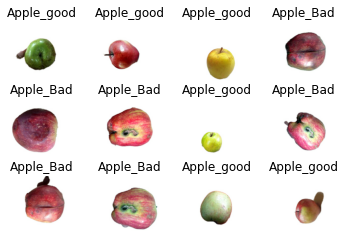

In [14]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
     ax = plt.subplot(3,4,i+1)   
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])
     plt.axis("off")      
  

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

57

In [18]:
len(val_ds)

7

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
57/57 [==============================] - 315s 3s/step - loss: 0.5967 - accuracy: 0.6711 - val_loss: 0.4182 - val_accuracy: 0.7991
Epoch 2/50
57/57 [==============================] - 94s 2s/step - loss: 0.4065 - accuracy: 0.8213 - val_loss: 0.3560 - val_accuracy: 0.8036
Epoch 3/50
57/57 [==============================] - 98s 2s/step - loss: 0.3152 - accuracy: 0.8624 - val_loss: 0.4959 - val_accuracy: 0.7634
Epoch 4/50
57/57 [==============================] - 98s 2s/step - loss: 0.3046 - accuracy: 0.8673 - val_loss: 0.6275 - val_accuracy: 0.7634
Epoch 5/50
57/57 [==============================] - 100s 2s/step - loss: 0.2814 - accuracy: 0.8799 - val_loss: 0.3992 - val_accuracy: 0.8036
Epoch 6/50
57/57 [==============================] - 102s 2s/step - loss: 0.2501 - accuracy: 0.8898 - val_loss: 0.4095 - val_accuracy: 0.8170
Epoch 7/50
57/57 [==============================] - 103s 2s/step - loss: 0.2566 - accuracy: 0.8882 - val_loss: 0.4905 - val_accuracy: 0.7589
Epoch 8/50
57/57

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 31s 316ms/step - loss: 0.2355 - accuracy: 0.9336


In [29]:
scores

[0.23548170924186707, 0.93359375]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 57}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

50

In [35]:
history.history['loss'][:5]

[0.5967194437980652,
 0.40647488832473755,
 0.31523409485816956,
 0.3046121299266815,
 0.2814467251300812]

In [36]:
Loss_val,acc_val = model.evaluate(train_ds,verbose=1)
print("Validation accuracy = %f ; Loss_v = %f" % (acc_val, Loss_val))

57/57 [==============================] - 26s 455ms/step - loss: 0.0209 - accuracy: 0.9940
Validation accuracy = 0.993969 ; Loss_v = 0.020864


In [37]:
Loss_test,acc_test = model.evaluate(test_ds,verbose=1)
print("Validation accuracy = %f ; Loss_v = %f" % (acc_test, Loss_test))

8/8 [==============================] - 3s 394ms/step - loss: 0.2355 - accuracy: 0.9336
Validation accuracy = 0.933594 ; Loss_v = 0.235482


In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

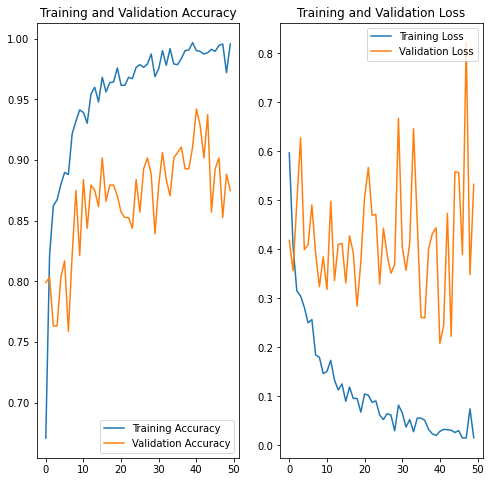

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

8/8 [==============================] - 3s 332ms/step
Classification report:
              precision    recall  f1-score   support

   Apple_Bad       0.48      0.43      0.45       130
  Apple_good       0.47      0.52      0.49       126

    accuracy                           0.47       256
   macro avg       0.47      0.47      0.47       256
weighted avg       0.47      0.47      0.47       256



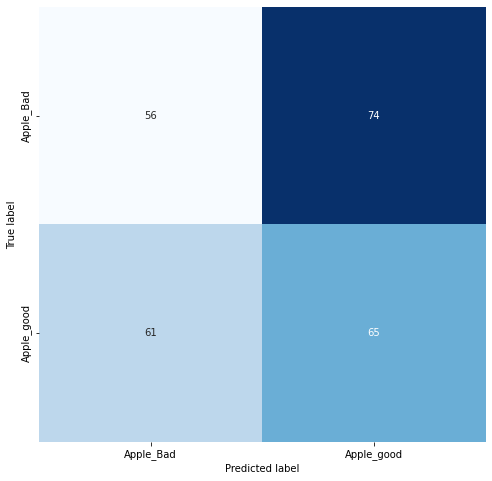

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the test set
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# Get the true labels for the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print("Classification report:")
print(report)

# Plot the confusion matrix with color-coded cells
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


first image to predict
actual label: Apple_good
1/1 [==============================] - 1s 802ms/step
predicted label: Apple_good


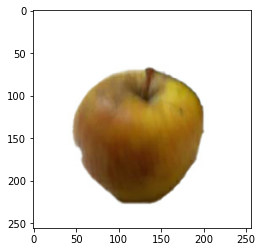

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


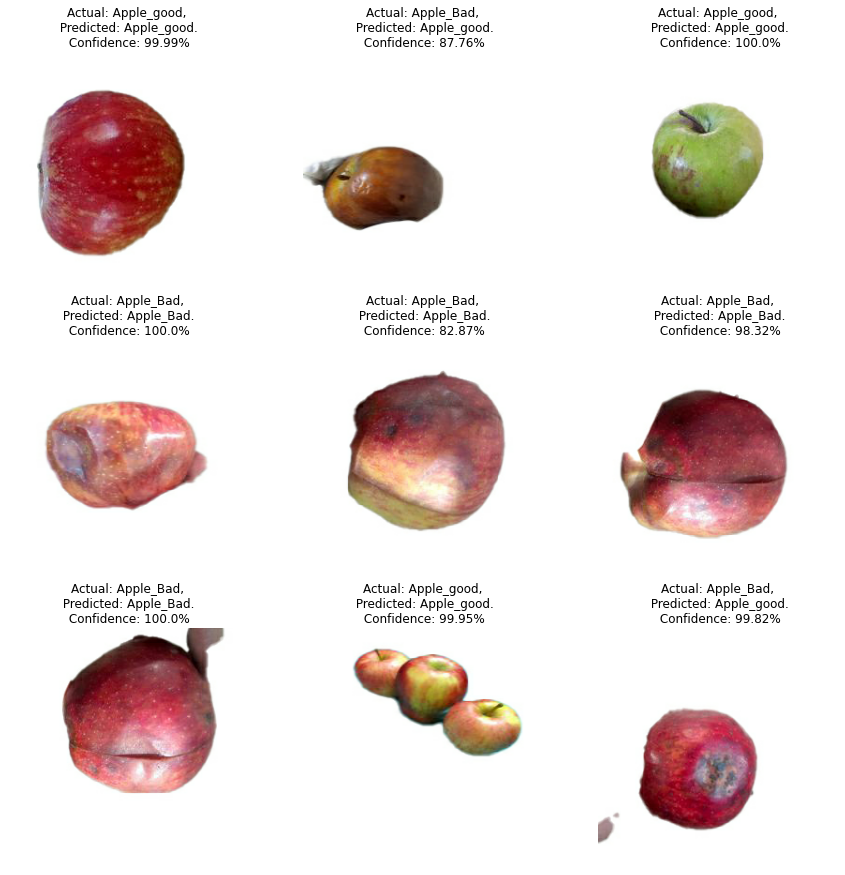

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version="Apple_model2_256_for_report"
model.save(f"../models/{model_version}")
model.save("../Applem2_256.h5")